## Create Example - Rasterize Single Year of Fire Data

In [3]:
#https://gis.stackexchange.com/questions/151339/rasterize-a-shapefile-with-geopandas-or-fiona-python
# use env:gdal_env_2.7v.2
import geopandas as gpd
import rasterio
from rasterio import features
import numpy as np
import os
from glob import glob


Set up your filenames

In [6]:
shp_fn = r'../Data/Actual/Fires/fire17_1.shp'

Open the file with GeoPANDAS read_file

In [7]:
fires = gpd.read_file(shp_fn)   


CHeck and fix datatype issues

In [4]:
#print fires.columns
#fires['YEAR_'].head()
#fires.YEAR_.unique()

In [4]:
print fires.dtypes.head()

YEAR_        object
STATE        object
AGENCY       object
UNIT_ID      object
FIRE_NAME    object
dtype: object


In [5]:
# subset to year and convert to integer
fires = fires[fires['YEAR_'].isin(['1984'])]
fires['YEAR_'] = fires['YEAR_'].astype(str).astype(int)
print fires.dtypes.head()

# create column of ones to rasterize for presence (1) of fire
fires['ONES'] = 1

YEAR_         int32
STATE        object
AGENCY       object
UNIT_ID      object
FIRE_NAME    object
dtype: object


Open the raster file you want to use as a template for feature burning using rasterio


In [11]:
example = r'../Data/Examples/aet-198403.tif'

rst = rasterio.open(example)
rst.bounds

BoundingBox(left=-374495.83635354, bottom=-616363.3341887, right=566504.16364646, top=592636.6658113)

copy and update the metadata from the input raster for the output


In [12]:
with rasterio.open(example) as src:
    array = src.read()
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1, compress='lzw',nodata=0)
    out_arr = src.read(1) # get data from first band, this gets updated in write
    print profile

{'count': 1, 'crs': CRS({u'lon_0': -120, u'ellps': u'GRS80', u'y_0': -4000000, u'no_defs': True, u'proj': u'aea', u'x_0': 0, u'units': u'm', u'towgs84': u'0,0,0,0,0,0,0', u'lat_2': 40.5, u'lat_1': 34, u'lat_0': 0}), 'interleave': 'band', 'dtype': 'float32', 'driver': u'GTiff', 'transform': Affine(1000.0, 0.0, -374495.83635354,
       0.0, -1000.0, 592636.6658113), 'height': 1209, 'width': 941, 'tiled': False, 'nodata': 0, 'compress': 'lzw'}


Now burn the features into the raster and write it out


In [13]:
output = r'../Data/Examples/3month_fire/fire_1984.tif' # any new file
    
# Write to tif, using the same profile as the source
with rasterio.open(output, 'w', **profile) as dst:
        
    # Write the product as a raster band to a new  file. For
    # the new file's profile, we start with the meta attributes of
    # the source file, but then change the band count to 1, set the
    # dtype to float, and specify LZW compression, missing = 0.

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(fires.geometry, fires.ONES))

    #rasterize shapes to raster values based on centroid 
    burned_value = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=dst.transform)
    # write out values 
    dst.write(burned_value,1)

The overall idea is to create an iterable containing tuples of (geometry, value), where the geometry is a shapely geometry and the value is what you want to burn into the raster at that geometry's location. Both Fiona and GeoPANDAS use shapely geometries so you are in luck there. In this example a generator is used to iterate through the (geometry,value) pairs which were extracted from the GeoDataFrame and joined together using zip().

## Create Annual Fire Rasters


In [10]:
import geopandas as gpd
import rasterio
from rasterio import features
import numpy as np
from joblib import Parallel, delayed
import multiprocessing

def fire_rasterizer(poly,raster_exmpl,raster_path_prefix,year_col_name='YEAR_',year_sub_list=range(1980,1990)):

    # years must be forced into a list
    if type(year_sub_list)==int:
        year_sub_list = [year_sub_list]
        
    # check if polygon is already geopandas dataframe if so, don't read again
    if ('fires' in locals()):
        if not(isinstance(fires, gpd.geodataframe.GeoDataFrame)): 
            fires = gpd.read_file(poly)
    else:
        fires = poly
    
    # subset to year and convert to integer
    fires = fires[fires.loc[:,year_col_name].isin( [str(i) for i in year_sub_list] )]

    # create column of ones to rasterize for presence (1) of fire
    fires['ONES'] = 1
   

    # get example metadata
    with rasterio.open(raster_exmpl) as src:
        array = src.read()
        profile = src.profile
        profile.update(dtype=rasterio.float32, count=1, compress='lzw',nodata=0)
        out_arr = src.read(1) # get data from first band, this gets updated in write

    # Write to tif, using the same profile as the source
    with rasterio.open(raster_path_prefix+str(year_sub_list[0])+'_'+str(year_sub_list[-1])+'.tif', 'w', **profile) as dst:

        # generator of geom, value pairs to use in rasterizing
        shapes = ((geom,value) for geom, value in zip(fires.geometry, fires.ONES))

        #rasterize shapes 
        burned_value = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=dst.transform)
        dst.write(burned_value,1)

In [17]:
# run individual date range
shp_fn = r'../Data/Actual/Fires/fire17_1.shp'

fire_rasterizer(poly = fires, raster_exmpl = r'../Data/Examples/aet-198403.tif',
                raster_path_prefix = r'../Data/Examples/fire_' ,year_col_name='YEAR_',
                year_sub_list=range(2008,2014))



C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\gdal_env_2.7v2\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
# run all individual years 1950 to 2018
shp_fn = r'../Data/Actual/Fires/fire17_1.shp'

for year in range(1950,2018):
    fire_rasterizer(poly = fires, 
                    raster_exmpl = r'../Data/Examples/aet-198403.tif',
                    raster_path_prefix = r'../Data/Examples\TestOutputs/fire_' ,
                    year_col_name='YEAR_',
                    year_sub_list=year)



C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\gdal_env_2.7v2\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [73]:
# Gather multiple date ranges
year_groups = []
for f, b in zip(range(1951,2015,5), range(1955,2020,5)):
    year_groups.append([f, b])
    
print(year_groups)


[[1951, 1955], [1956, 1960], [1961, 1965], [1966, 1970], [1971, 1975], [1976, 1980], [1981, 1985], [1986, 1990], [1991, 1995], [1996, 2000], [2001, 2005], [2006, 2010], [2011, 2015]]


In [14]:
# run all 5 year date ranges from 1950 to 2018
shp_fn = r'../Data/Actual/Fires/Inputs/fire17_1.shp'

for year in year_groups:
    fire_rasterizer(poly = fires, 
                    raster_exmpl = r'../Data/Examples/aet-198403.tif',
                    raster_path_prefix = r'../Data/Actual/Fires/Outputs/fire_' ,
                    year_col_name='YEAR_',
                    year_sub_list=year)

C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv2\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Move climate data into correct year_group folders

In [133]:
import shutil
from pathlib import Path


def chk_mak_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
def int_globber(ints):
    # create regular expression for specific year 
    return ''.join(["["+i+"]" for i in str(ints)])

def path_globber(a_dir,year_group,metric):
     # gets all in_path files in a date range 
     l = [glob(os.path.join(a_dir,metric+"-"+int_globber(i)+"*")) 
              for i in range(year_group[0],year_group[1])]
     return  [item for sublist in l for item in sublist]

    
in_dir = 'E:/HIST 1000m/'
out_dir = '../Data/Actual/Climate'

for metric in ['ppt','tmx','aet','cwd','pet','pck']:   
    for year_group in year_groups:
        # check for and make output dir
        year_group_dir = str(year_group[0])+"_"+ str(year_group[1])
        out_dir_metric = os.path.join(out_dir,year_group_dir,metric)
        chk_mak_dir(out_dir_metric)
        
        # make lists of files to move and destinations
        files_to_move = path_globber(in_dir, year_group,metric)
        files_out_move =[os.path.join(out_dir_metric, 
                                      os.path.basename(i)) for i in files_to_move]
        #print(pd.DataFrame([files_to_move,files_out_move])) # print examples
        
        # move files 
        for index, item in enumerate(files_to_move ):
            if Path(files_out_move[index]).is_file():
                next
            else:
                shutil.move(files_to_move[index], files_out_move[index])


In [112]:
import pandas as pd
pd.DataFrame([files_to_move,files_out_move])



,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,E:/HIST 1000m\aet-200601.tif,E:/HIST 1000m\aet-200602.tif,E:/HIST 1000m\aet-200603.tif,E:/HIST 1000m\aet-200604.tif,E:/HIST 1000m\aet-200605.tif,E:/HIST 1000m\aet-200606.tif,E:/HIST 1000m\aet-200607.tif,E:/HIST 1000m\aet-200608.tif,E:/HIST 1000m\aet-200609.tif,E:/HIST 1000m\aet-200610.tif,...,E:/HIST 1000m\aet-200903.tif,E:/HIST 1000m\aet-200904.tif,E:/HIST 1000m\aet-200905.tif,E:/HIST 1000m\aet-200906.tif,E:/HIST 1000m\aet-200907.tif,E:/HIST 1000m\aet-200908.tif,E:/HIST 1000m\aet-200909.tif,E:/HIST 1000m\aet-200910.tif,E:/HIST 1000m\aet-200911.tif,E:/HIST 1000m\aet-200912.tif
1,../Data/Actual/Climate//2011_2015\aet-200601.tif,../Data/Actual/Climate//2011_2015\aet-200602.tif,../Data/Actual/Climate//2011_2015\aet-200603.tif,../Data/Actual/Climate//2011_2015\aet-200604.tif,../Data/Actual/Climate//2011_2015\aet-200605.tif,../Data/Actual/Climate//2011_2015\aet-200606.tif,../Data/Actual/Climate//2011_2015\aet-200607.tif,../Data/Actual/Climate//2011_2015\aet-200608.tif,../Data/Actual/Climate//2011_2015\aet-200609.tif,../Data/Actual/Climate//2011_2015\aet-200610.tif,...,../Data/Actual/Climate//2011_2015\aet-200903.tif,../Data/Actual/Climate//2011_2015\aet-200904.tif,../Data/Actual/Climate//2011_2015\aet-200905.tif,../Data/Actual/Climate//2011_2015\aet-200906.tif,../Data/Actual/Climate//2011_2015\aet-200907.tif,../Data/Actual/Climate//2011_2015\aet-200908.tif,../Data/Actual/Climate//2011_2015\aet-200909.tif,../Data/Actual/Climate//2011_2015\aet-200910.tif,../Data/Actual/Climate//2011_2015\aet-200911.tif,../Data/Actual/Climate//2011_2015\aet-200912.tif


# Rasterize State Polygon

function to rasterize polygons (assigns 1s to features) and can provide buffer at multiples of example raster resolution.

In [9]:
from tsraster import prep
import rasterio
from matplotlib import pyplot

In [4]:
# rasterize state polygon using same parameters as raster_ex, add 10 cell buffer
prep.poly_rasterizer(poly = 'F:/Boundary/StatePoly.shp', raster_ex = r'F:/3month/aet-198401.tif',
                raster_path_prefix = r'../Data/Examples\TestOutputs/StatePoly_buf',buffer_poly_cells=10)

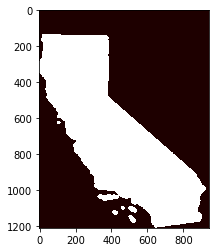

In [10]:
dataset = rasterio.open(r'../Data/Examples/TestOutputs/StatePoly_buf.tif')


pyplot.imshow(dataset.read(1), cmap='pink')
pyplot.show()